In [9]:
%matplotlib notebook
import torch
import torch.nn as nn
import sys
sys.path.append('train_eval')
sys.path.append('preprocess')
from preprocess_blender import *
from IPython.display import Image, display
import math
from utils import group_points_2

In [10]:
def simple_plot(points):
    from matplotlib import pyplot
    from mpl_toolkits.mplot3d import Axes3D
    fig = pyplot.figure()
    ax = Axes3D(fig)
    ax.scatter(points[:,0], points[:,1], points[:,2], c='b')
    ax.view_init(90,-90)

In [52]:
def read_and_plot(path):
    pc = np.loadtxt(path)
    simple_plot(pc)

In [120]:
def preprocess_b(depth_map_path, gt_path):
    depth_scale = 0.0010000000474974513
    f           = 320.8097839355469
    
    # 1. Read depth files 
    img_width = 256
    img_height = 256
    bb_left = 0
    bb_top = 0
    bb_right = img_width
    bb_bottom = img_height
    bb_width = bb_right - bb_left
    bb_height = bb_bottom - bb_top
    valid_pixel_num = bb_width * bb_height
    # variables in array are float32
    # hand_depth = np.asarray(struct.unpack('{}f'.format(valid_pixel_num), f.read(4 * valid_pixel_num))).reshape((bb_height,         bb_width))
    depth_map = cv2.imread(depth_map_path, cv2.IMREAD_UNCHANGED)
    depth_map = depth_map[:,:,0] #rgb channels have same information. take one
    
    # 2. Convert Depth to XYZ
    PIXEL_SIZE_mm = 1/8
    FOCAL_BLENDER_mm = 35 # focal length
    MAX_DEPTH = 20 # z clip
    foot_3d = np.zeros((valid_pixel_num, 3))
    for i in range(0, bb_height):
        for j in range(0, bb_width):
            idx = j * bb_height + i
            z = depth_map[i][j]
            foot_3d[idx][0] = -1 * (img_width / 2. - (j + bb_left)) * PIXEL_SIZE_mm / FOCAL_BLENDER_mm * z
            foot_3d[idx][1] = (img_height / 2. - (i + bb_top)) * PIXEL_SIZE_mm / FOCAL_BLENDER_mm * z 
            foot_3d[idx][2] = z

    # remove entries where all 3D values are equal to 0
    foot_points = foot_3d[(foot_3d[:,0] != 0) | (foot_3d[:,1] != 0) | (foot_3d[:,2] != 0)]
    # remove entries where z value is above MAX_Z
    foot_points = foot_points[abs(foot_points[:,2])<MAX_DEPTH]

    # 3. Create OBB
    pca = PCA(n_components=3)
    pca.fit(foot_points)
    coeff = np.transpose(pca.components_)

    # Check if this rotation is what we want
    if coeff[1][0] < 0 : coeff[:,0] = -1 * coeff[:,0]
    if coeff[2][2] < 0 : coeff[:,2] = -1 * coeff[:,2]
    coeff[:,1] = np.cross(coeff[:,2], coeff[:,0])
    foot_points_rotate = np.matmul(foot_points, coeff)
        
    # 4. Sampling
    NUM_POINTS = foot_points.shape[0]
    SAMPLE_NUM = 1024

    if NUM_POINTS < SAMPLE_NUM: # repeat points if the total number is less than sampled
        tmp = math.floor(SAMPLE_NUM / NUM_POINTS)
        rand_ind = []
        for i in range(tmp):
            rand_ind.append([i for i in range(NUM_POINTS)])
        rand_ind = np.append(np.asarray(rand_ind), np.random.choice(NUM_POINTS, SAMPLE_NUM % NUM_POINTS))
    else:
        rand_ind = np.random.choice(NUM_POINTS, SAMPLE_NUM)

    foot_points_sampled = foot_points[rand_ind,:]
    foot_points_rotate_sampled = foot_points_rotate[rand_ind, :]

    # 5. Compute Surface Normal
    normals = pptk.estimate_normals(points=foot_points, k=30, r=np.inf, verbose=False)
    normals_sampled = normals[rand_ind]
    sensor_center = np.array([0, 0, 0])

    for k in range(SAMPLE_NUM):
        p1 = sensor_center - foot_points_sampled[k, :]
        angle = np.arctan2(np.linalg.norm(np.cross(p1, normals_sampled[k, :])), np.dot(p1, normals_sampled[k, :]))
        if angle > math.pi / 2 or angle < -1 * math.pi / 2: normals_sampled[k, :] = -1 * normals_sampled[k, :]

    normals_sampled_rotate = np.matmul(normals_sampled, coeff)
    
    # 6. Normalize Point Cloud
    x_min, x_max = np.min(foot_points_rotate[:, 0]), np.max(foot_points_rotate[:, 0])
    y_min, y_max = np.min(foot_points_rotate[:, 1]), np.max(foot_points_rotate[:, 1])
    z_min, z_max = np.min(foot_points_rotate[:, 2]), np.max(foot_points_rotate[:, 2])

    SCALE = 1.2
    bb3d_x_len = SCALE * (x_max - x_min)
    bb3d_y_len = SCALE * (y_max - y_min)
    bb3d_z_len = SCALE * (z_max - z_min)
    max_bb3d_len = max(bb3d_x_len, bb3d_y_len, bb3d_z_len)
    foot_points_normalized_sampled = foot_points_rotate_sampled / max_bb3d_len

    if NUM_POINTS < SAMPLE_NUM: offset = np.mean(foot_points_rotate, axis=0) / max_bb3d_len
    else: offset = np.mean(foot_points_normalized_sampled, axis=0)

    foot_points_normalized_sampled -= offset

    # 7. FPS Sampling
    pc = np.hstack((foot_points_normalized_sampled, normals_sampled_rotate))

    # 1st level
    sampled_idx_l1 = farthest_point_sampling_fast(foot_points_normalized_sampled, 512)
    other_idx = np.setdiff1d(np.asarray([i for i in range(SAMPLE_NUM)]), sampled_idx_l1)
    new_idx = np.append(sampled_idx_l1, other_idx)
    pc = pc[new_idx, :]

    # 2nd level
    sampled_idx_l2 = farthest_point_sampling_fast(pc[0:512, 0:2], 128)
    other_idx = np.setdiff1d(np.asarray([i for i in range(512)]), sampled_idx_l2)
    new_idx = np.append(sampled_idx_l2, other_idx)
    pc[0:512, :] = pc[new_idx, :]
   
    return pc
#     return pc, coeff, max_bb3d_len, offset

(128, 6)


<IPython.core.display.Javascript object>


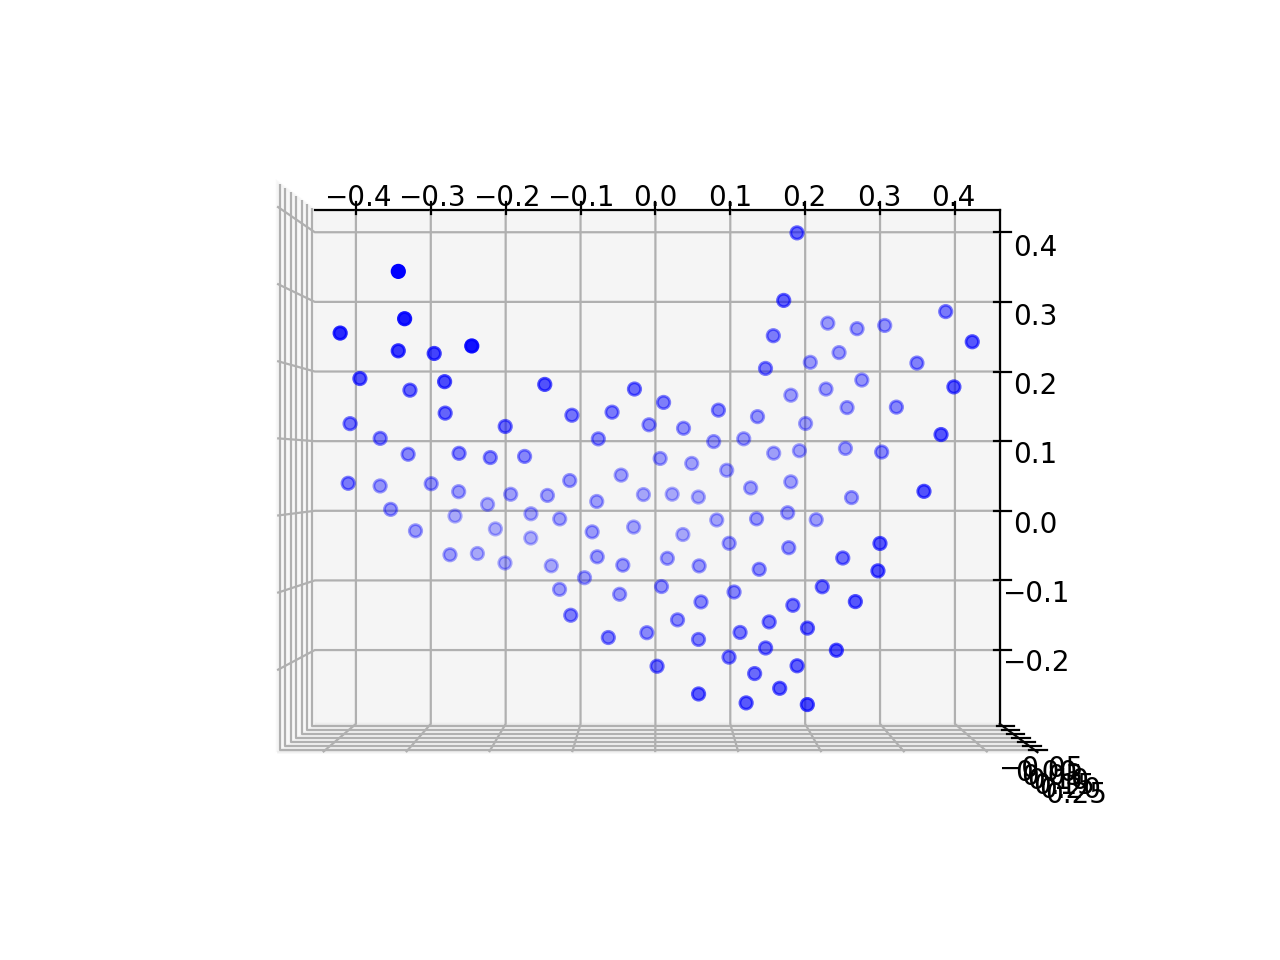

In [121]:
data_root = '/home/andrew/Dev/HandPointNet/data/samples/'
depth_map = os.path.join(data_root,'0000.exr')
gt        = os.path.join(data_root,'0000_joint_pos.txt')
pc        = preprocess_b(depth_map, gt)
point_cloud = torch.from_numpy(pc.reshape((1,1024,6))).float()

(128, 3)


<IPython.core.display.Javascript object>


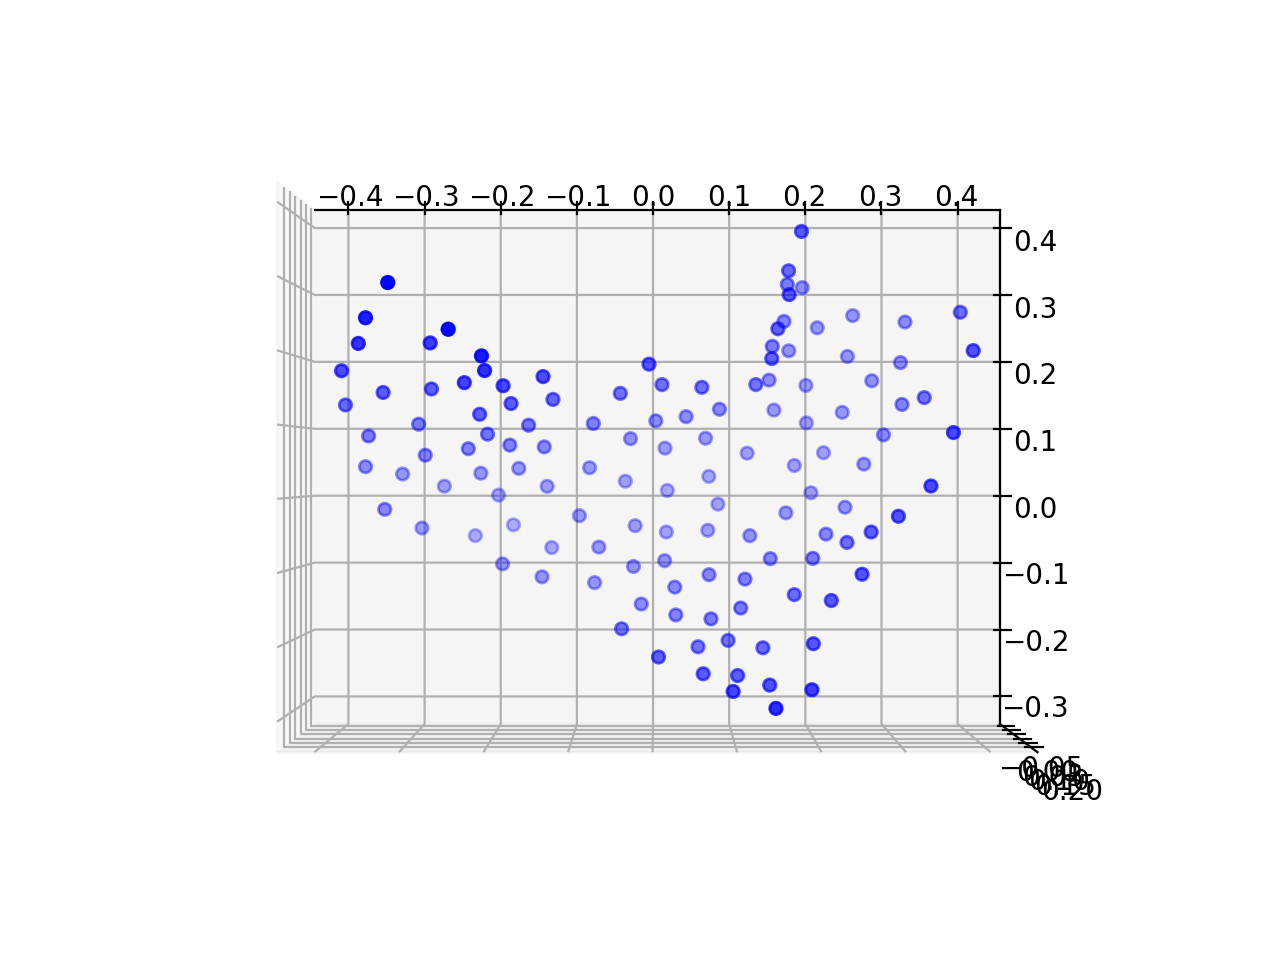

(array([], dtype=int64),)


In [122]:
# read_and_plot("/home/andrew/Dev/Monocle/tmp.txt")
pc = np.loadtxt("/home/andrew/Dev/Monocle/tmp.txt")
print(pc.shape)
# pc = pc[abs(pc[:,1])<3]
simple_plot(pc)
print(np.where( pc[:,1] > 3.0 ))

NameError: name 'Variable' is not defined